In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import PIL
import pathlib

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Dropout, Flatten,Activation, BatchNormalization,MaxPooling2D
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import EarlyStopping


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

In [21]:
images_dir = pathlib.Path('/kaggle/input/scogo-dataset') 

class_images_dict = {
    'device': list(images_dir.glob('device_images/*')),
    'rack': list(images_dir.glob('rack_images/*'))
}

class_labels_dict = {
    'device': 0,
    'rack': 1
}

In [22]:
IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_CHANNELS = 3
X, Y = [], []

for class_name, classes in class_images_dict.items():
    print(class_name)
    for image in classes:
        img = cv2.imread(str(image))
        if isinstance(img,type(None)): 
            #print('image not found')
            continue
            
        elif ((img.shape[0] >= IMAGE_HEIGHT) and  (img.shape[1] >=IMAGE_WIDTH)):
            resized_img = cv2.resize(img,(IMAGE_WIDTH,IMAGE_HEIGHT))
            X.append(resized_img)
            Y.append(class_labels_dict[class_name])
        else:
            #print("Invalid Image")
            continue

device
rack


In [23]:
X = np.array(X)
Y = np.array(Y)
X.shape, Y.shape

((200, 256, 256, 3), (200,))

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0, test_size=0.2)
print(len(X_train),len(Y_train))
print(len(X_test),len(Y_test))

160 160
40 40


In [25]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model

In [26]:
# Load the pre-trained VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
base_model.trainable = False
# Add custom classification layers on top of the pre-trained model
last_output = base_model.output
x = tf.keras.layers.Flatten()(last_output)  # Flatten the output layer to 1 dimension
x = tf.keras.layers.Dense(1024, activation='relu')(x)   # Add a fully connected layer with 1024 hidden units and ReLU activation
x = tf.keras.layers.Dropout(0.6)(x) # Add dropout for regularization
predictions = Dense(1, activation='sigmoid')(x)  

In [27]:
vgg19_model = Model(inputs=base_model.input, outputs=predictions)

In [28]:
vgg19_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [29]:
vgg19_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the path where you want to save the best weights
checkpoint_path = 'scogo_best.h5'

# Define the callback to save only the best weights based on validation accuracy
checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True,
                             mode='max')

# Train the model with the callback
history = vgg19_model.fit(X_train, Y_train,
                    batch_size=32,
                    verbose=1,
                    epochs=20,
                    validation_data=(X_test, Y_test),  # Provide validation data here
                    callbacks=[checkpoint])  # Pass the callback here

Epoch 1/20
5/5 [==============================] - ETA: 0s - loss: 7.3517 - accuracy: 0.8313 
Epoch 1: val_accuracy improved from -inf to 0.97500, saving model to scogo_best.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 87s 18s/step - loss: 7.3517 - accuracy: 0.8313 - val_loss: 3.8047 - val_accuracy: 0.9750
Epoch 2/20
5/5 [==============================] - ETA: 0s - loss: 1.7655 - accuracy: 0.9688 
Epoch 2: val_accuracy did not improve from 0.97500
5/5 [==============================] - 87s 18s/step - loss: 1.7655 - accuracy: 0.9688 - val_loss: 0.7876 - val_accuracy: 0.9500
Epoch 3/20
5/5 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000 
Epoch 3: val_accuracy did not improve from 0.97500
5/5 [==============================] - 83s 17s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.2706 - val_accuracy: 0.9750
Epoch 4/20
5/5 [==============================] - ETA: 0s - loss: 1.7567 - accuracy: 0.9875  
Epoch 4: val_accuracy did not improve from 0.97500
5/5 [==============================] - 83s 18s/step - loss: 1.7567 - accuracy: 0.9875 - val_loss: 9.5960 - val_accuracy: 0.9500
Epoch 5/20
5/5 [==============================]

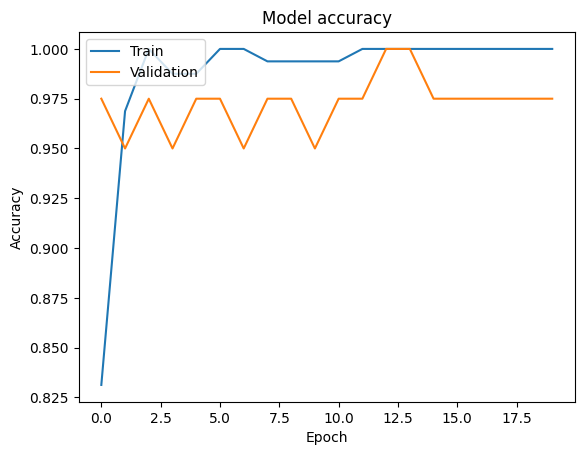

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])  # Plot validation accuracy
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [32]:
import os
import numpy as np
import pandas as pd
from keras.models import load_model
from PIL import Image

def predict_classes_in_directory(directory_path):
    classes = ["device", "rack"]
    predictions = []

    # Load the saved model
    model_path = '/kaggle/working/scogo_best.h5'
    model = load_model(model_path)

    for file_name in os.listdir(directory_path):
        if file_name.endswith(('.jpg', '.jpeg', '.png', '.gif')):  # Check if it's an image file
            image_path = os.path.join(directory_path, file_name)
            fileImage = Image.open(image_path).convert("RGB").resize([IMAGE_WIDTH, IMAGE_HEIGHT], Image.LANCZOS)
            image = np.array(fileImage)
            myimage = image.reshape(1, IMAGE_WIDTH, IMAGE_HEIGHT, 3)

            # Make predictions
            my_predicted_image = model.predict(myimage)

            # Assuming threshold of 0.5 for binary classification
            predicted_class = classes[int(my_predicted_image > 0.5)]
            predictions.append(predicted_class)

    # Create a DataFrame to store results
    df = pd.DataFrame({'Filename': os.listdir(directory_path), 'Predicted_Class': predictions})
    return df

# Path to the directory containing images
images_directory = '/kaggle/input/scogo-dataset/Unseen Data'

# Predict classes for images in the directory
results_df = predict_classes_in_directory(images_directory)

# Save results to CSV
results_csv_path = '/kaggle/working/predictions.csv'
results_df.to_csv(results_csv_path, index=False)

print(f"Predictions saved to {results_csv_path}.")


1/1 [==============================] - 1s 632ms/step


/tmp/ipykernel_33/3331351656.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = classes[int(my_predicted_image > 0.5)]


1/1 [==============================] - 0s 443ms/step
Predictions saved to /kaggle/working/predictions.csv.


In [33]:
import pandas as pd
df = pd.read_csv('/kaggle/working/predictions.csv')
df['Actual_Class'] = df['Filename'].str.split('_').str[0]
df.head()

,Filename,Predicted_Class,Actual_Class
0,rack_11.jpg,rack,rack
1,rack_24.jpg,rack,rack
2,device_7.jpg,device,device
3,rack_37.jpg,rack,rack
4,rack_2.jpg,rack,rack


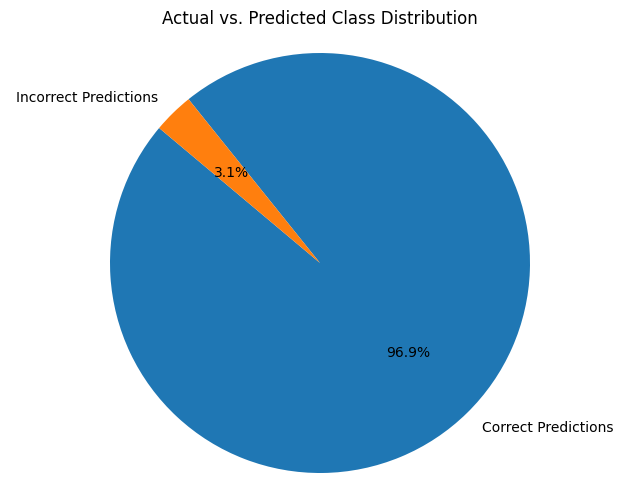

In [34]:
# Count the number of cases where actual class matches predicted class
correct_predictions = (df['Actual_Class'] == df['Predicted_Class']).sum()

# Count the number of cases where actual class doesn't match predicted class
incorrect_predictions = len(df) - correct_predictions

# Create labels and values for the pie chart
labels = ['Correct Predictions', 'Incorrect Predictions']
values = [correct_predictions, incorrect_predictions]

# Plot the pie chart
plt.figure(figsize=(8, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Actual vs. Predicted Class Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [36]:
correct_predictions, incorrect_predictions

(62, 2)

In [37]:
accuracy_rate = correct_predictions / len(df)
print(f"Out of 500K images, ",500000*accuracy_rate, " images will be predicted right.")

Out of 500K images,  484375.0  images will be predicted right.
